# CNN on CIFAR-10 Dataset

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import time

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid
from sklearn.metrics import confusion_matrix

In [3]:
transform = transforms.ToTensor()

## Load Data

In [5]:
train_data = datasets.CIFAR10(root='../Data', train=True, download=True, transform=transform)

In [6]:
test_data = datasets.CIFAR10(root='../Data', train=False, download=True, transform=transform)

In [7]:
train_data

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [8]:
test_data

Dataset CIFAR10
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [9]:
torch.manual_seed(101)
train_loader = DataLoader(train_data,batch_size=10,shuffle=True)
test_loader = DataLoader(test_data,batch_size=10,shuffle=False)

In [10]:
class_names = ['plane', '  car', ' bird', '  cat', ' deer', '  dog', ' frog', 'horse', ' ship', 'truck']

## View a Batch of Images

Label: [    1     5     8     1     6     1     6     3     7     9]
Class:    car   dog  ship   car  frog   car  frog   cat horse truck


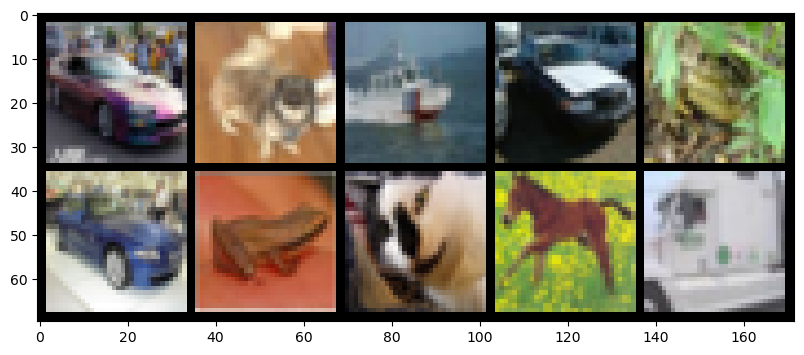

In [12]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

# Grab the first batch of 10 images
for images,labels in train_loader: 
    break

# Print the labels
print('Label:', labels.numpy())
print('Class: ', *np.array([class_names[i] for i in labels]))

# Print the images
im = make_grid(images, nrow=5)  # the default nrow is 8
plt.figure(figsize=(10,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

In [13]:
labels

tensor([1, 5, 8, 1, 6, 1, 6, 3, 7, 9])

## Define the Model

In [15]:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 12, 5, 1)  # changed from (1, 6, 5, 1)
        self.conv2 = nn.Conv2d(12, 16, 3, 1)
        self.fc1 = nn.Linear(6*6*16, 120)   # changed from (4*4*16) to fit 32x32 images with 3x3 filters
        self.fc2 = nn.Linear(120,84)
        self.fc3 = nn.Linear(84,84)
        self.fc4 = nn.Linear(84, 10)

    def forward(self, X):
        X = F.relu(self.conv1(X))
        X = F.max_pool2d(X, 2, 2)
        X = F.relu(self.conv2(X))
        X = F.max_pool2d(X, 2, 2)
        X = X.view(-1, 6*6*16)
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = F.relu(self.fc3(X))
        X = self.fc4(X)
        return F.log_softmax(X, dim=1)

In [16]:
torch.manual_seed(101)
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)

In [17]:
total = 0

for param in model.parameters():
    total += param.numel()
    print(param.numel())
    
print(f'The total number of parameters is {total}')

900
12
1728
16
69120
120
10080
84
7056
84
840
10
The total number of parameters is 90050


In [18]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

## Train the Model

In [20]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed   

epoch:  0  batch: 1000 [ 10000/50000]  loss: 1.77443409  accuracy:  23.520%
epoch:  0  batch: 2000 [ 20000/50000]  loss: 1.49475837  accuracy:  28.425%
epoch:  0  batch: 3000 [ 30000/50000]  loss: 1.30071425  accuracy:  31.627%
epoch:  0  batch: 4000 [ 40000/50000]  loss: 1.65316045  accuracy:  33.765%
epoch:  0  batch: 5000 [ 50000/50000]  loss: 1.30213678  accuracy:  35.756%
epoch:  1  batch: 1000 [ 10000/50000]  loss: 1.93501818  accuracy:  45.570%
epoch:  1  batch: 2000 [ 20000/50000]  loss: 1.35195136  accuracy:  46.935%
epoch:  1  batch: 3000 [ 30000/50000]  loss: 1.34957242  accuracy:  47.607%
epoch:  1  batch: 4000 [ 40000/50000]  loss: 1.38099122  accuracy:  48.355%
epoch:  1  batch: 5000 [ 50000/50000]  loss: 1.74698639  accuracy:  48.922%
epoch:  2  batch: 1000 [ 10000/50000]  loss: 1.06775689  accuracy:  52.980%
epoch:  2  batch: 2000 [ 20000/50000]  loss: 0.55480146  accuracy:  53.700%
epoch:  2  batch: 3000 [ 30000/50000]  loss: 1.38071299  accuracy:  54.130%
epoch:  2  b

## Save the Model

In [22]:
torch.save(model.state_dict(), 'CIFAR10-CNN-Model.pt')

## Evaluate the Model

### Plot the loss and accuracy comparisons

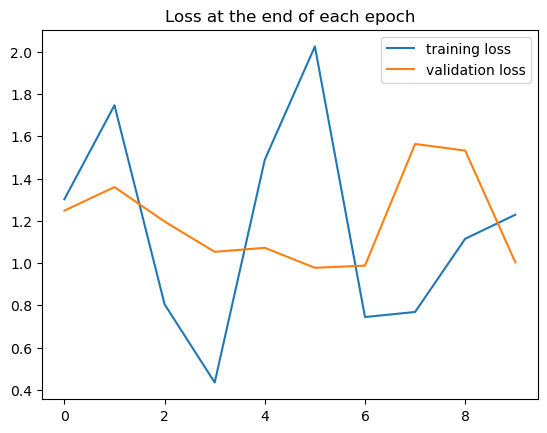

In [25]:
with torch.no_grad():
    plt.plot(train_losses, label='training loss')
    plt.plot(test_losses, label='validation loss')
    plt.title('Loss at the end of each epoch')
    plt.legend();

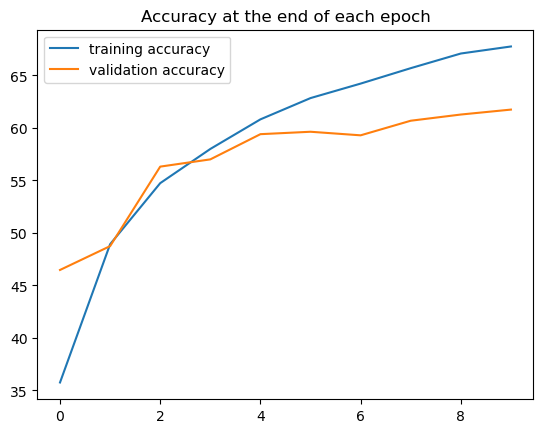

In [26]:
with torch.no_grad():
    plt.plot([t/500 for t in train_correct], label='training accuracy')
    plt.plot([t/100 for t in test_correct], label='validation accuracy')
    plt.title('Accuracy at the end of each epoch')
    plt.legend();

### Evaluate Test Data

In [28]:
print(test_correct) # contains the results of all 10 epochs
print()
print(f'Test accuracy: {test_correct[-1].item()*100/10000:.3f}%') # print the most recent result as a percent

[tensor(4647), tensor(4874), tensor(5631), tensor(5700), tensor(5940), tensor(5963), tensor(5929), tensor(6068), tensor(6127), tensor(6174)]

Test accuracy: 61.740%


### Display the confusion matrix

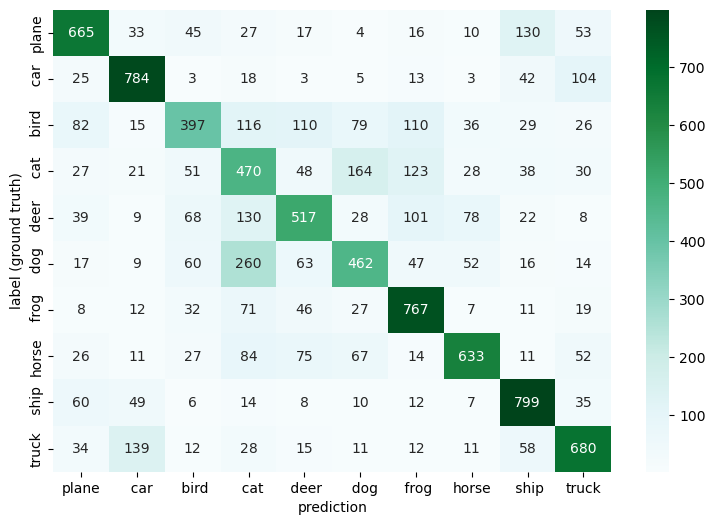

In [30]:
# Create a loader for the entire the test set
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()

arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();

## Examine the Misses

In [32]:
misses = np.array([])
for i in range(len(predicted.view(-1))):
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
        
# Display the number of misses
len(misses)

3826

In [33]:
# Display the first 8 index positions
misses[:8]

array([    4,     6,     7,    12,    17,    20,    24,    25],
      dtype=int64)

In [34]:
# Set up an iterator to feed batched rows
r = 8   # row size
row = iter(np.array_split(misses,len(misses)//r+1))

Index: [    4     6     7    12    17    20    24    25]
Label: [    6     1     6     5     7     7     5     2]
Class:   frog   car  frog   dog horse horse   dog  bird

Guess: [    3     3     2     6     9     9     4     6]
Class:    cat   cat  bird  frog truck truck  deer  frog


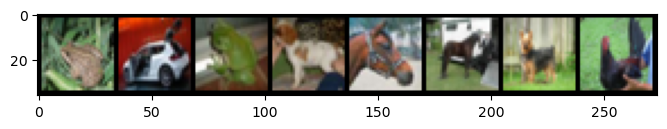

In [35]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:5}')) # to widen the printed array

nextrow = next(row)
lbls = y_test.index_select(0,torch.tensor(nextrow)).numpy()
gues = predicted.index_select(0,torch.tensor(nextrow)).numpy()
print("Index:", nextrow)
print("Label:", lbls)
print("Class: ", *np.array([class_names[i] for i in lbls]))
print()
print("Guess:", gues)
print("Class: ", *np.array([class_names[i] for i in gues]))

images = X_test.index_select(0,torch.tensor(nextrow))
im = make_grid(images, nrow=r)
plt.figure(figsize=(8,4))
plt.imshow(np.transpose(im.numpy(), (1, 2, 0)));

### Load A Saved Model

In [37]:
# Instantiate the model and load saved parameters
model2 = ConvolutionalNetwork()
model2.load_state_dict(torch.load('CIFAR10-CNN-Model.pt'))
model2.eval()

ConvolutionalNetwork(
  (conv1): Conv2d(3, 12, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(12, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=84, bias=True)
  (fc4): Linear(in_features=84, out_features=10, bias=True)
)

In [38]:
test_load_all = DataLoader(test_data, batch_size=10000, shuffle=False)

with torch.no_grad():
    correct = 0
    for X_test, y_test in test_load_all:
        y_val = model2(X_test)
        predicted = torch.max(y_val,1)[1]
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 6174/10000 =  61.740%


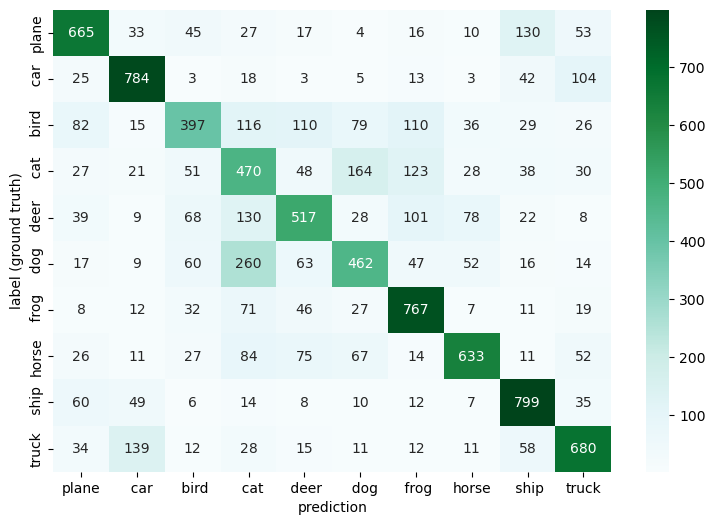

In [39]:
# Display the confusion matrix as a heatmap
arr = confusion_matrix(y_test.view(-1), predicted.view(-1))
df_cm = pd.DataFrame(arr, class_names, class_names)
plt.figure(figsize = (9,6))
sns.heatmap(df_cm, annot=True, fmt="d", cmap='BuGn')
plt.xlabel("prediction")
plt.ylabel("label (ground truth)")
plt.show();